In [1]:
# Setup and Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Setting the style for seaborn
sns.set(style='whitegrid')

# To suppress warnings
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Step 2: Load the b Dataset
train = pd.read_csv('./../data/sentimet-analysis/train.csv')
test = pd.read_csv('./../data/sentimet-analysis/test.csv')

In [3]:
# Display first few rows of the both data
print("Training Dataset:")
print(train.head())
print("\nTest Dataset:")
print(test.head())

Training Dataset:
   Id                                               Body Sentiment Type
0   1  rule 2 no metes about polarizing political top...        neutral
1   2                                                NaN        neutral
2   3  no politics danger now i can make a propaganda...       negative
3   4                       i am the senate gets stabbed        neutral
4   5                                  is this a suicide        neutral

Test Dataset:
   Id                                               Body
0   1  rule 2 no metes about polarizing political top...
1   2                                                NaN
2   3  no politics danger now i can make a propaganda...
3   4                       i am the senate gets stabbed
4   5                                  is this a suicide


In [4]:
#Missing Values in Training Dataset
train.isnull().sum()

Id                  0
Body              228
Sentiment Type      0
dtype: int64

In [5]:
# Class distribution
train['Sentiment Type'].value_counts()

Sentiment Type
neutral     1010
positive     632
negative     358
Name: count, dtype: int64

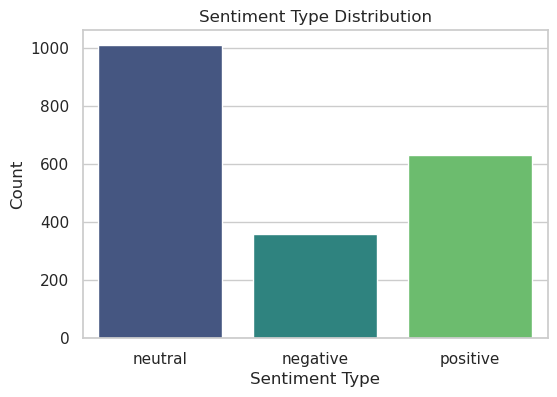

In [6]:
# Plotting class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='Sentiment Type', palette='viridis')
plt.title('Sentiment Type Distribution')
plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.show()

In [7]:
# Drop rows where any column has missing values
train= train.dropna()
test=test.dropna()
# Drop rows where specific column(s) have missing values
train=train.dropna(subset=['Body'])
test=test.dropna(subset=['Body'])

In [7]:
# Step 4: Data Cleaning and Preprocessing
import nltk
nltk.data.path.append('/usr/share/nltk_data')
nltk.download('wordnet', download_dir='/usr/share/nltk_data')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'<[^>]*>', '', text)  # Remove HTML tags
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatize and remove stopwords
    else:
        text = ''
    return text

# Apply text cleaning
train['Body'] = train['Body'].apply(clean_text)
test['Body'] =test['Body'].apply(clean_text)

# Display the cleaned text
print("\nCleaned Text in Training Data:")
print(train['Body'].head())

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Cleaned Text in Training Data:
0    rule mete polarizing political topic vulnerabl...
1                                                     
2    politics danger make propaganda meme telling p...
3                                   senate get stabbed
4                                              suicide
Name: Body, dtype: object


In [8]:
# Feature Extraction using TF-IDF

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(train['Body'])
X_test_tfidf = tfidf_vectorizer.transform(test['Body'])

# Show the shape of transformed data
print("\nTF-IDF feature matrix shape for training data:", X_train_tfidf.shape)
print("TF-IDF feature matrix shape for test data:", X_test_tfidf.shape)


TF-IDF feature matrix shape for training data: (2000, 5000)
TF-IDF feature matrix shape for test data: (2000, 5000)


In [9]:
#Model Training

# Target variable
y_train = train['Sentiment Type']

# Initialize and train logistic regression model
#model = RandomForestClassifier()
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

# Predict on the training data to see initial accuracy
y_train_pred = model.predict(X_train_tfidf)

In [10]:
# Model evaluation
print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred))
print("\nClassification Report on Training Data:")
print(classification_report(y_train, y_train_pred))


Training Accuracy: 0.885

Classification Report on Training Data:
              precision    recall  f1-score   support

    negative       0.99      0.57      0.72       358
     neutral       0.84      1.00      0.91      1010
    positive       0.95      0.89      0.92       632

    accuracy                           0.89      2000
   macro avg       0.92      0.82      0.85      2000
weighted avg       0.90      0.89      0.88      2000



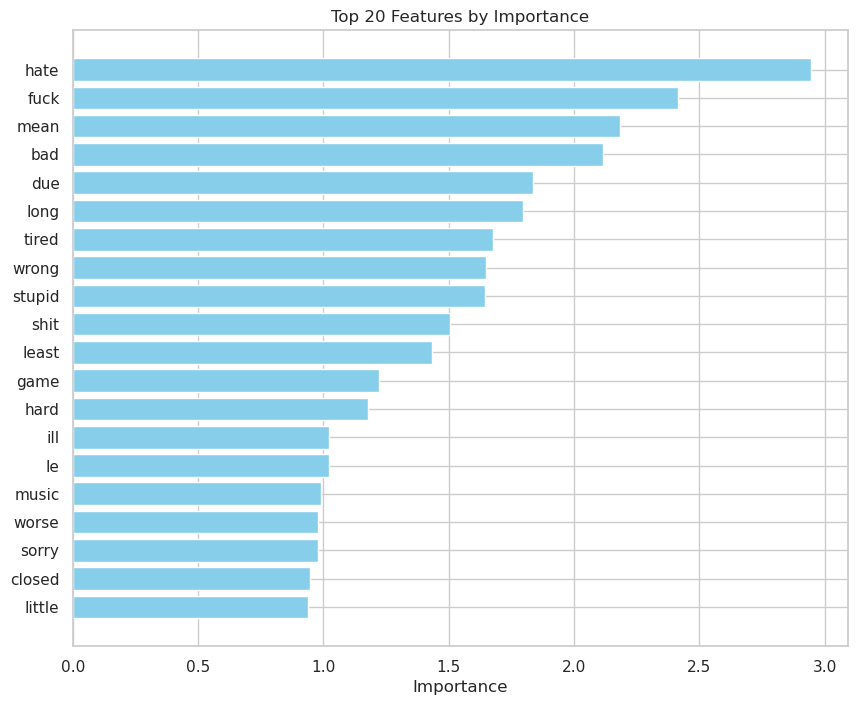

In [11]:
# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0] 

# Create a DataFrame to hold feature names and their importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients) 
})
# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


# Select the top 20 features
top_features = feature_importance.head(20)
#plot important feature
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Features by Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [12]:
# Predict on test data
y_test_pred = model.predict(X_test_tfidf)

# Create a DataFrame for the test predictions
test_results = test.copy()
test_results['Sentiment Type'] = y_test_pred

# Save the predictions to a CSV file
test_results[['Id', 'Body', 'Sentiment Type']].to_csv('test_predictions.csv', index=False)

In [13]:
import joblib


# model = trained logistic regression model
# tfidf = trained TF-IDF vectorizer

# Save the model and the TF-IDF vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']